In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import matplotlib

# !pip install mne
import mne
from mne.preprocessing import ICA

# !pip install meeg_tools
from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs
from meeg_tools.utils.raw import read_raw_measurement, filter_raw
from meeg_tools.utils.log import update_log

In [2]:
channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

In [3]:
%matplotlib qt

Preprocessing

In [4]:
for x in range(2, 3):
    if (x < 10 and x != 5):
        URL="https://raw.githubusercontent.com/baiyuankok/EEG-Analysis/master/STEW%20Original%20Dataset/sub0"+str(x)+"_hi.txt"
    elif (x >=10 and x not in [24, 42]):
        URL="https://raw.githubusercontent.com/baiyuankok/EEG-Analysis/master/STEW%20Original%20Dataset/sub"+str(x)+"_hi.txt"
    else:
        continue

    print("sub" + str(x) + ":")
    eegData = pd.read_csv(URL, sep="  ", header=None, engine='python')
    eegData.columns = channels
    sampling_freq = 128  # Hz
    info = mne.create_info(ch_names=channels, sfreq=sampling_freq, ch_types='eeg')
    raw = mne.io.RawArray(eegData.transpose(), info)
    
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

#     raw.plot(n_channels=14, scalings='auto')
    raw.resample(256, npad="auto")
    
    raw.filter(1, 30, fir_design='firwin', picks=['eeg'])  # band-pass filter from 1 to 30 frequency over just EEG channel and not EEG channel
    raw.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference
#     raw.plot(n_channels=14, scalings='auto')
    
#     events_from_annot, event_dict = mne.events_from_annotations(raw)
#     print("Events from annot: ")
#     print(events_from_annot)
#     print("Event Dict: ")
#     print(event_dict)

#     event_dict = {'74':74, '75':75, '76':76}             
#     reject_criteria = dict(eeg=100e-6)                            
    
#     epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
#                     reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])

#     epochs = mne.Epochs(raw_ica, events_from_annot, event_id=event_dict, tmin=0, tmax=2, baseline=(0, 0), event_repeated='drop', preload=True)
#     epochs = mne.make_fixed_length_epochs(raw, duration = 10,overlap=0, preload=False)
#     epochs = mne.Epochs(raw, tmin=0, tmax=2, baseline=(0, 0), event_repeated='drop', preload=True)
    settings['epochs']
    epochs = create_epochs(raw=raw)
    epochs = epochs.copy().load_data().pick_channels(channels, ordered=True)
    epochs_faster = prepare_epochs_for_ica(epochs=epochs)

    ica = mne.preprocessing.ICA(n_components=0.999999, random_state=97, method='fastica')
    ica.fit(epochs_faster)  
    
    ica.plot_components(title="Decomposed ICA Components")  # Plot all decomposed components

    
#     ica = mne.preprocessing.ICA(n_components=50, random_state=97, method='fastica')
#     ica.fit(epochs)
#     ica.plot_components()

sub2:
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 sec)

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Creating epochs fr

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=13, n_times=38400
    Range : 0 ... 38399 =      0.000 ...   149.996 secs
Ready.
Using matplotlib as 2D backend.


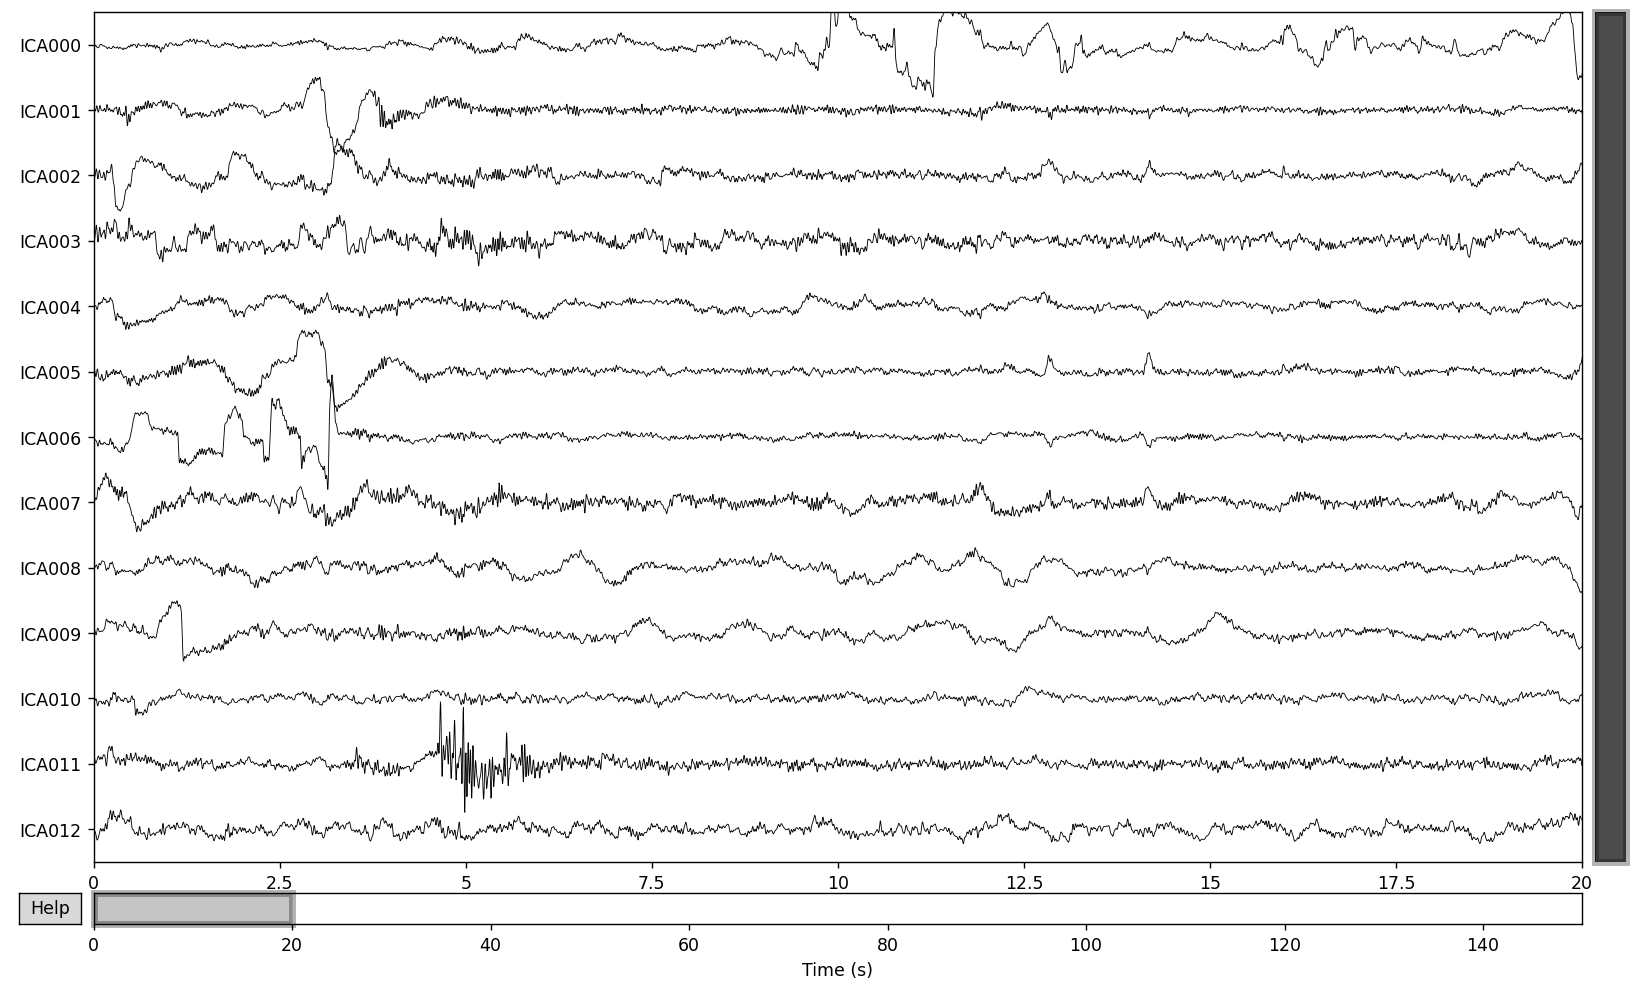

In [5]:
%matplotlib qt
ica.plot_sources(raw)

In [6]:
ica.exclude = [0] 
epochs_ica = ica.apply(epochs_faster)   

Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (13 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


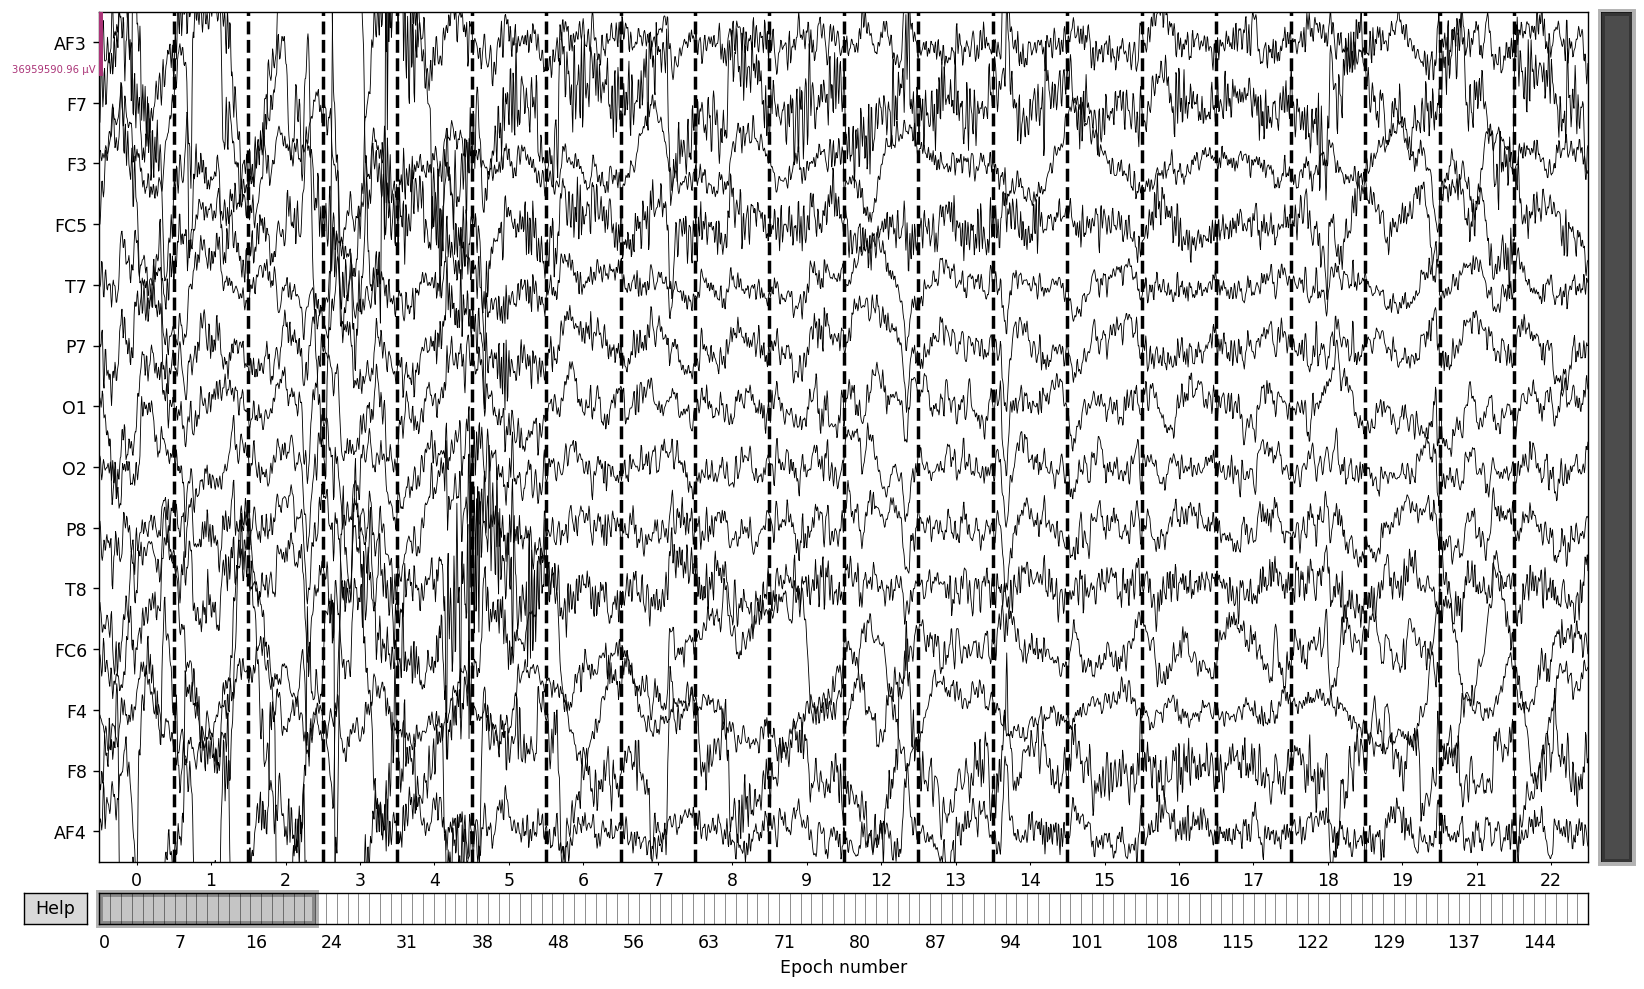

In [7]:
epochs_ica.plot(n_channels=14, scalings='auto')

In [8]:
reject_log = run_autoreject(epochs_ica, n_jobs=11, subset=False)

Fitting autoreject on (n=138) epochs: 
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/138 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4

AUTOREJECT report
There are 45 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 98 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [9]:
reject_log.plot_epochs(epochs_ica, scalings='auto');

In [10]:
epochs_autoreject = epochs_ica.copy().drop(reject_log.report, reason='AUTOREJECT')

Dropped 98 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 16, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 42, 44, 45, 47, 48, 50, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 100, 101, 106, 107, 108, 109, 110, 111, 114, 116, 117, 119, 120, 121, 122, 130, 131, 132, 135, 136, 137


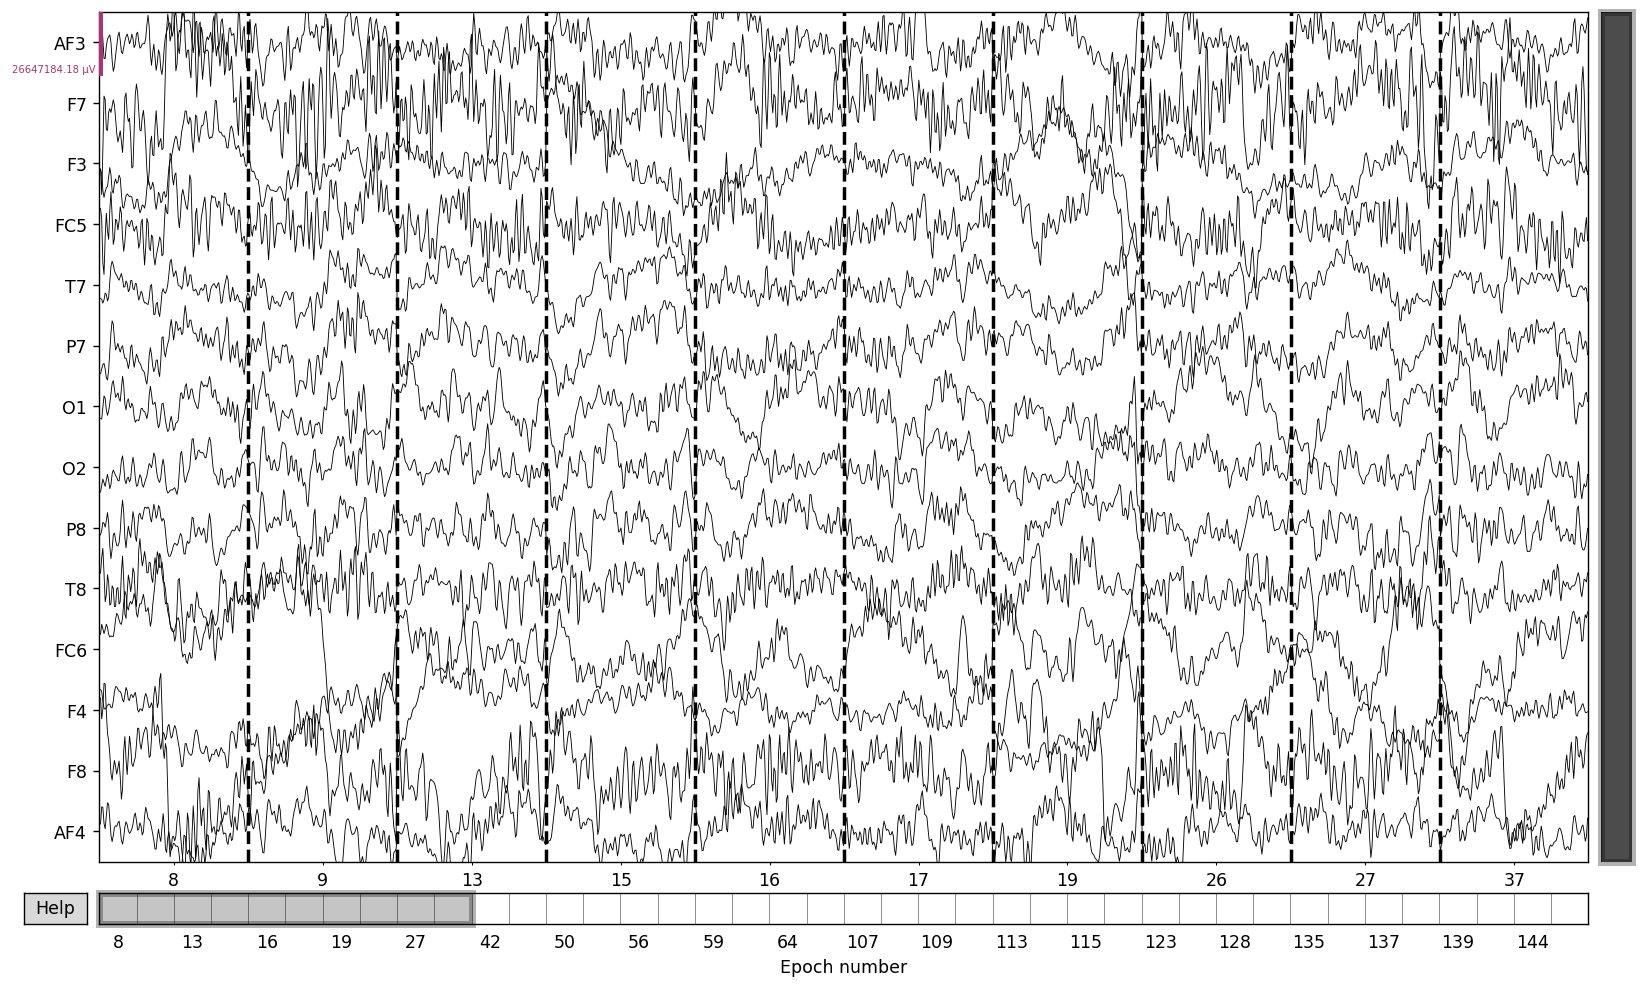

In [11]:
epochs_autoreject.plot(n_epochs=10, n_channels=14, scalings='auto',)

In [12]:
print(epochs_autoreject.info)

<Info | 9 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: Average EEG reference: on
 sfreq: 256.0 Hz
>


In [13]:
epochs_autoreject.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


<Epochs |  40 events (all good), 0 - 1 sec, baseline off, ~1.1 MB, data loaded,
 '1': 40>

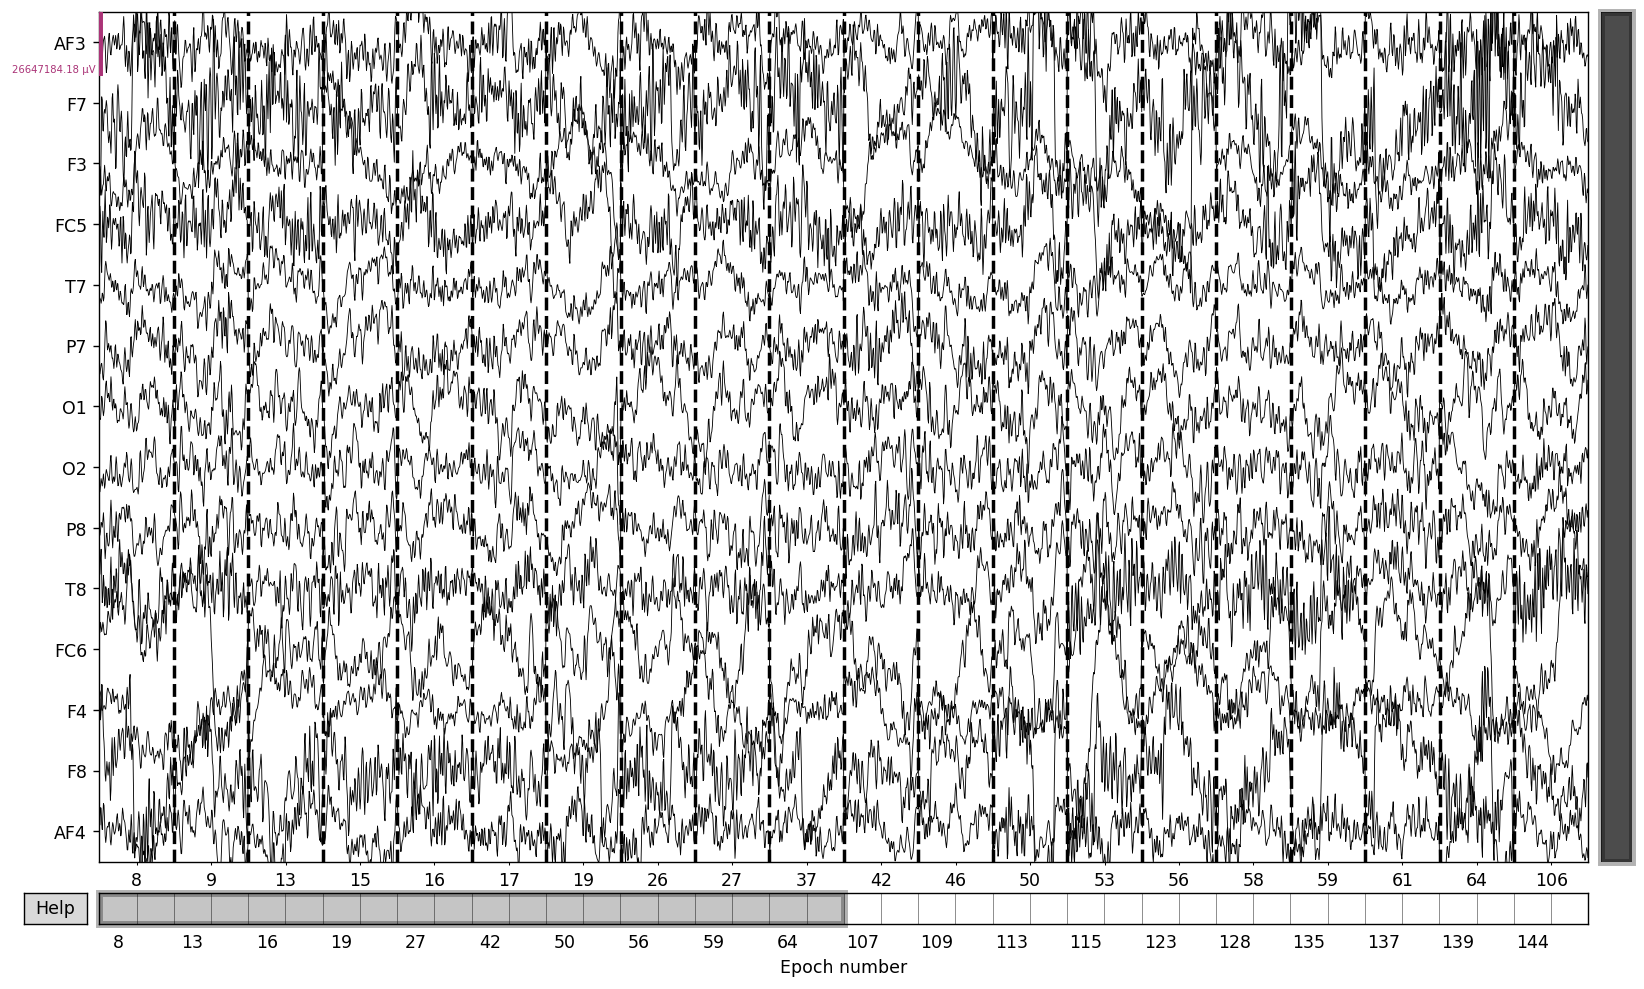

In [14]:
epochs_autoreject.plot(n_channels=32,
                       # group_by='position',
                       scalings='auto')

In [15]:
# index, scale_time, scalings = ['epoch', 'time'], 1e3, dict(grad=1e13)

# df = epochs_autoreject.to_data_frame(picks=None, scalings=scalings,
#                           index=index)

In [16]:
# df

In [17]:
# df.to_csv (r'D:\New folder\Semester 7\CAT 400\STEW Original Dataset\export_dataframe.csv ', index = False, header=True)

In [18]:
epochs_autoreject.save(r"D:\New folder\Semester 7\CAT 400\STEW Finalised Dataset\01_hi_epo.fif")

Testing for manual step

In [19]:
# URL="https://raw.githubusercontent.com/baiyuankok/EEG-Analysis/master/STEW%20Original%20Dataset/sub01_hi.txt"
# eegData = pd.read_csv(URL, sep="  ", header=None, engine='python')
# eegData.columns = channels
# sampling_freq = 128  # Hz
# info = mne.create_info(ch_names=channels, sfreq=sampling_freq, ch_types='eeg')
# raw = mne.io.RawArray(eegData.transpose(), info)

# raw = raw.filter(1., None, fir_design='firwin')
# raw.plot(n_channels=14, scalings='auto')

In [20]:
# raw = raw.notch_filter(60, picks=['eeg'], filter_length='auto', phase='zero')
# raw.plot(n_channels=14, scalings='auto')

In [21]:
# ica = ICA(n_components=14, method='infomax', random_state=42)
# ica.fit(raw, decim=10)

In [22]:
# ica.plot_components();


Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
Dropped 0 epochs: 
Channels marked as bad: none
